# Vision - Attention for Image Classification

By [Akshaj Verma](https://akshajverma.com)

This notebook takes you through 3 visual attention mechanisms - `Squeeze and Excitation [CVPR 2018]`, `CBAM: Convolutional Block Attention Module [ECCV 2018]`, and `Self-Attention mechanism from Non-local Neural Networks [CVPR 2018]`. We'll use the CIFAR dataset for our analysis and visualize heatmaps using the `GradCAM [ICCV 2017]` algorithm.

In [1]:
import random
import numpy as np
import pandas as pd

import cv2
from PIL import Image

import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [3]:
%matplotlib inline
sns.set_style("darkgrid")

## Define Paths and Set GPU

Let's define the path for our data.

In [4]:
torch.cuda.set_device(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

root_dir = "data/computer_vision/cifar10"
print("The data lies here =>", root_dir)

We're using => cuda
The data lies here => data/computer_vision/cifar10


## Define transforms

Let's define a dictionary to hold the image transformations for train/test sets. The `ToTensor` operation in PyTorch convert all tensors to lie between `(0, 1)`.

In [5]:
image_transforms = {
    "train": transforms.Compose([transforms.ToTensor()]),
    "test": transforms.Compose([transforms.ToTensor()]),
}

## Initialize Datasets

### Train + Validation Dataset

We 2 dataset folders with us - **Train** and **Test**. 

We will further divide our **Train** set as **Train + Val**. 

In [6]:
cifar10_dataset = datasets.CIFAR10(
    root_dir, train=True, download=True, transform=image_transforms["train"]
)

cifar10_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/computer_vision/cifar10
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

### Class <=> ID Mapping of Output

The `class_to_idx` function is pre-built in PyTorch. It returns class ID's present in the dataset.

In [7]:
cifar10_dataset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

We will now construct a reverse of this dictionary; a mapping of ID to class. 

In [8]:
idx2class = {v: k for k, v in cifar10_dataset.class_to_idx.items()}
idx2class

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

### Get Train and Validation Samples

We use `SubsetRandomSampler` to make our train and validation loaders. `SubsetRandomSampler` is used so that our each batch receives a random distribution of classes. 

We could've also split our dataset into 2 parts - train and val ie. make 2 `Subsets`. But this is simpler because our data loader will pretty much handle everything now.



`SubsetRandomSampler(indices)` takes as input the indices of data.

We first create our samplers and then we'll pass it to our dataloaders.

* Create a list of indices.
* Shuffle the indices.
* Split the indices based on train-val percentage.
* Create SubsetRandomSampler.

In [9]:
def create_samplers(dataset, train_percent):
    dataset_size = len(dataset)
    dataset_indices = list(range(dataset_size))

    np.random.shuffle(dataset_indices)

    train_split_index = int(np.floor(train_percent * dataset_size))

    train_idx = dataset_indices[:train_split_index]
    val_idx = dataset_indices[train_split_index:]

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    return train_sampler, val_sampler

In [10]:
train_sampler, val_sampler = create_samplers(cifar10_dataset, train_percent=0.8)

### Test Dataset

Now that we're done with train and val data, let's load our test dataset. 

In [11]:
cifar10_dataset_test = datasets.CIFAR10(
    root_dir, train=False, download=True, transform=image_transforms["test"]
)

cifar10_dataset_test

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/computer_vision/cifar10
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

### Train, Validation, and Test Dataloader

Now, we will pass the samplers to our dataloader. Note that `shuffle=True` cannot be used when you're using the `SubsetRandomSampler`.

In [12]:
BATCH_SIZE = 64

In [13]:
train_loader = DataLoader(
    dataset=cifar10_dataset, shuffle=False, batch_size=BATCH_SIZE, sampler=train_sampler
)

val_loader = DataLoader(
    dataset=cifar10_dataset, shuffle=False, batch_size=1, sampler=val_sampler
)

test_loader = DataLoader(dataset=cifar10_dataset_test, shuffle=False, batch_size=1)

## Explore The Data

In [14]:
single_batch = next(iter(train_loader))

`single_batch` is a list of 2 elements. The first element (0th index) contains the image tensors while the second element (1st index) contains the output labels. 

Here's the first element of the list which is a tensor. This tensor is of the shape `(batch, channels, height, width)`. 

In [15]:
single_batch[0].shape

torch.Size([64, 3, 32, 32])

Here are the output labels for the batch.

In [16]:
print("Output label tensor shape: ", single_batch[1].shape)
print("\nOutput label tensors: ", single_batch[1])

Output label tensor shape:  torch.Size([64])

Output label tensors:  tensor([7, 4, 5, 3, 6, 7, 3, 7, 8, 7, 1, 7, 9, 9, 0, 2, 7, 3, 6, 8, 4, 3, 7, 2,
        9, 7, 3, 2, 8, 1, 4, 1, 1, 8, 3, 2, 3, 6, 8, 0, 3, 5, 5, 1, 6, 2, 7, 1,
        5, 0, 6, 5, 7, 5, 2, 9, 6, 0, 2, 8, 4, 4, 1, 4])


To plot the image, we'll use `plt.imshow` from matloptlib. It expects the image dimension to be `(height, width, channels)`. We'll `.permute()` our single image tensor to plot it. 

In [17]:
# Selecting the first image tensor from the batch.
single_image = single_batch[0][0]
single_image.shape

torch.Size([3, 32, 32])

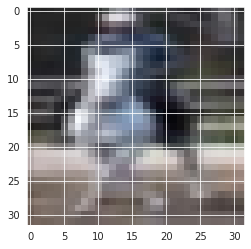

In [18]:
plt.imshow(single_image.permute(1, 2, 0))

PyTorch has made it easier for us to plot the images in a grid straight from the batch. 

We first extract out the image tensor from the list (returned by our dataloader) and set `nrow`. Then we use the `plt.imshow()` function to plot our grid. Remember to `.permute()` the tensor dimensions!

In [19]:
# We do single_batch[0] because each batch is a list
# where the 0th index is the image tensor and 1st index is the output label.
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)

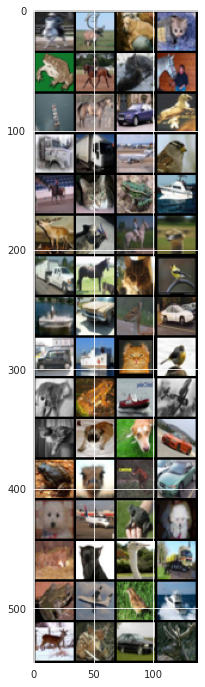

In [20]:
plt.figure(figsize=(12, 12))
plt.imshow(single_batch_grid.permute(1, 2, 0))

## Model Details

Our architecture is simple. We use 4 blocks of `Conv` layers. Each block consists of `Convolution` + `BatchNorm` + `ReLU` + `Dropout` layers. We will not use an `FC` layer at the end. We'll stick with a `Conv` layer. 

### Multi-class Accuracy Function

Before we start our training, let's define a function to calculate accuracy per epoch. This function takes `y_pred` and `y_test` as input arguments. We then apply softmax to `y_pred` and extract the class which has a higher probability. After that, we compare the the predicted classes and the actual classes to calculate the accuracy.

In [21]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim=1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim=1)

    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)

    acc = torch.round(acc) * 100

    return acc

### Base Module

In [22]:
class ResModule(nn.Module):
    def __init__(self, c_in, c_out, channel_reduction_factor):
        super(ResModule, self).__init__()

        self.c_in = c_in
        self.c_out = c_out
        self.channel_reduction_factor = channel_reduction_factor

        self.conv_start = nn.Sequential(
            nn.Conv2d(
                in_channels=self.c_in,
                out_channels=self.c_in,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(num_features=self.c_in),
            nn.ReLU(),
        )

        self.conv_mid = nn.Sequential(
            nn.Conv2d(
                in_channels=self.c_in,
                out_channels=self.c_in // self.channel_reduction_factor,
                kernel_size=1,
                stride=1,
                padding=0,
            ),
            nn.BatchNorm2d(num_features=self.c_in // self.channel_reduction_factor),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=self.c_in // self.channel_reduction_factor,
                out_channels=self.c_in,
                kernel_size=1,
                stride=1,
                padding=0,
            ),
            nn.BatchNorm2d(num_features=self.c_in),
            nn.ReLU(),
        )

        self.conv_end = nn.Sequential(
            nn.Conv2d(
                in_channels=self.c_in,
                out_channels=self.c_out,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(num_features=self.c_out),
            nn.ReLU(),
        )

    def forward(self, x):
        o = self.conv_start(x)
        o = self.conv_mid(o)
        o += x
        o = self.conv_end(o)

        return o

### Attention Modules

#### Squeeze And Excitation [[paper](https://arxiv.org/abs/1709.01507)]

In [23]:
class SqueezeExcitationModule(nn.Module):
    def __init__(self, c_in, channel_reduction_factor):
        super(SqueezeExcitationModule, self).__init__()

        self.c_in = c_in
        self.channel_reduction_factor = channel_reduction_factor

        self.squeeze = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.excitation = nn.Sequential(
            nn.Conv2d(
                in_channels=self.c_in,
                out_channels=self.c_in // self.channel_reduction_factor,
                kernel_size=1,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=self.c_in // self.channel_reduction_factor,
                out_channels=self.c_in,
                kernel_size=1,
                stride=1,
                padding=0,
            ),
            nn.Sigmoid(),
        )

    def forward(self, x):
        o = self.squeeze(x)
        o = self.excitation(x)
        x = x * o

        return x


class ResSqexModule(nn.Module):
    def __init__(self, c_in, c_out, channel_reduction_factor):
        super(ResSqexModule, self).__init__()

        self.c_in = c_in
        self.c_out = c_out
        self.channel_reduction_factor = channel_reduction_factor

        self.conv_start = nn.Sequential(
            nn.Conv2d(
                in_channels=self.c_in,
                out_channels=self.c_in,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(num_features=self.c_in),
            nn.ReLU(),
        )

        self.sqex = SqueezeExcitationModule(
            c_in=self.c_in, channel_reduction_factor=self.channel_reduction_factor
        )

        self.conv_end = nn.Sequential(
            nn.Conv2d(
                in_channels=self.c_in,
                out_channels=self.c_out,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(num_features=self.c_out),
            nn.ReLU(),
        )

    def forward(self, x):
        o = self.conv_start(x)
        o = self.sqex(o)
        o = o + x
        o = self.conv_end(o)

        return o

#### CBAM: Convolutional Block Attention Module [[paper](https://openaccess.thecvf.com/content_ECCV_2018/papers/Sanghyun_Woo_Convolutional_Block_Attention_ECCV_2018_paper.pdf)]

In [24]:
class CamModule(nn.Module):
    def __init__(self, c_in, channel_reduction_factor=2):
        super(CamModule, self).__init__()

        self.c_in = c_in
        self.channel_reduction_factor = channel_reduction_factor

        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.max_pool = nn.AdaptiveMaxPool2d(output_size=(1, 1))

        self.conv_block = nn.Sequential(
            nn.Conv2d(
                in_channels=self.c_in,
                out_channels=self.c_in // self.channel_reduction_factor,
                kernel_size=1,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=self.c_in // self.channel_reduction_factor,
                out_channels=self.c_in,
                kernel_size=1,
                stride=1,
                padding=0,
            ),
        )

    def forward(self, x):
        g = self.avg_pool(x)
        m = self.max_pool(x)

        g_out = self.conv_block(g)
        m_out = self.conv_block(m)

        o = g_out + m_out
        o = torch.sigmoid(o)

        x = x * o

        return x


class SamModule(nn.Module):
    def __init__(self):
        super(SamModule, self).__init__()

        self.conv = nn.Conv2d(
            in_channels=2, out_channels=1, kernel_size=3, stride=1, padding=1
        )

    def forward(self, x):
        o = self.channel_pool(x)
        o = self.conv(o)
        o = torch.sigmoid(o)

        x = x * o

        return x

    def channel_pool(self, x):
        return torch.cat(
            (torch.max(x, dim=1)[0].unsqueeze(1), torch.mean(x, dim=1).unsqueeze(1)),
            dim=1,
        )


class ResCbamModule(nn.Module):
    def __init__(self, c_in, c_out, channel_reduction_factor):
        super(ResCbamModule, self).__init__()

        self.c_in = c_in
        self.c_out = c_out
        self.channel_reduction_factor = channel_reduction_factor

        self.conv_start = nn.Sequential(
            nn.Conv2d(
                in_channels=self.c_in,
                out_channels=self.c_in,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(num_features=self.c_in),
            nn.ReLU(),
        )
        self.cam = CamModule(
            c_in=self.c_in, channel_reduction_factor=self.channel_reduction_factor
        )
        self.sam = SamModule()

        self.conv_end = nn.Sequential(
            nn.Conv2d(
                in_channels=self.c_in,
                out_channels=self.c_out,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(num_features=self.c_out),
            nn.ReLU(),
        )

    def forward(self, x):
        o = self.conv_start(x)
        o = self.cam(o)
        o = self.sam(o)
        o = o + x
        o = self.conv_end(o)

        return o

#### Self-Attention [[paper](https://arxiv.org/abs/1711.07971)]

In [25]:
class SelfAttentionModule(nn.Module):
    def __init__(self, c_in, k):
        super(SelfAttentionModule, self).__init__()

        self.c_in = c_in
        self.k = k

        self.cnn_f = nn.Conv2d(
            in_channels=c_in, out_channels=c_in // k, kernel_size=1, stride=1
        )
        self.cnn_g = nn.Conv2d(
            in_channels=c_in, out_channels=c_in // k, kernel_size=1, stride=1
        )
        self.cnn_h = nn.Conv2d(
            in_channels=c_in, out_channels=c_in, kernel_size=1, stride=1
        )

        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):

        batch_size = x.shape[0]

        f = self.cnn_f(x)  # B x C x H x W
        g = self.cnn_g(x)  # B x C x H x W
        h = self.cnn_h(x)  # B x C x H x W

        f = f.view(batch_size, self.c_in // self.k, -1).permute(0, 2, 1)  # B x N x C/k
        g = g.view(batch_size, self.c_in // self.k, -1)  # B x C/k x N
        h = h.view(batch_size, self.c_in, -1)  # B x C x N

        s = torch.bmm(f, g)  # B x N x N

        b = F.softmax(s, dim=1)  # B x N x N

        hb = torch.bmm(h, b)  # B x C x N

        hb = hb.view(*x.shape)  # B x C x H x W

        o = self.gamma * hb + x  # B x C x H x W

        return o


class ResSattnModule(nn.Module):
    def __init__(self, c_in, c_out, channel_reduction_factor):
        super(ResSattnModule, self).__init__()

        self.c_in = c_in
        self.c_out = c_out
        self.channel_reduction_factor = channel_reduction_factor

        self.conv_start = nn.Sequential(
            nn.Conv2d(
                in_channels=self.c_in,
                out_channels=self.c_in,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(num_features=self.c_in),
            nn.ReLU(),
        )

        self.sattn = SelfAttentionModule(
            c_in=self.c_in, k=self.channel_reduction_factor
        )

        self.conv_end = nn.Sequential(
            nn.Conv2d(
                in_channels=self.c_in,
                out_channels=self.c_out,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(num_features=self.c_out),
            nn.ReLU(),
        )

    def forward(self, x):
        o = self.conv_start(x)
        o = self.sattn(o)
        o = o + x
        o = self.conv_end(o)

        return o

### Test Modules

In [26]:
x = torch.randn(4, 64, 32, 32)

base = ResModule(c_in=64, c_out=128, channel_reduction_factor=2)
sqex = ResSqexModule(c_in=64, c_out=128, channel_reduction_factor=2)
cbam = ResCbamModule(c_in=64, c_out=128, channel_reduction_factor=2)
sattn = ResSattnModule(c_in=64, c_out=128, channel_reduction_factor=2)

base(x).shape, sqex(x).shape, cbam(x).shape, sattn(x).shape

(torch.Size([4, 128, 32, 32]),
 torch.Size([4, 128, 32, 32]),
 torch.Size([4, 128, 32, 32]),
 torch.Size([4, 128, 32, 32]))

### Main Classifier Model

In [27]:
CHANNEL_FACTOR = 8

In [28]:
class ModelImageClassifier(nn.Module):
    def __init__(self, attn_type):
        super(ModelImageClassifier, self).__init__()

        self.attn_type = attn_type
        self.num_classes = 10

        self.first_conv = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1
        )

        self.layer_1 = self.conv_block(
            attn_type=self.attn_type,
            c_in=64,
            c_out=128,
            channel_reduction_factor=CHANNEL_FACTOR,
        )
        self.layer_2 = self.conv_block(
            attn_type=self.attn_type,
            c_in=128,
            c_out=256,
            channel_reduction_factor=CHANNEL_FACTOR,
        )
        self.layer_3 = self.conv_block(
            attn_type=self.attn_type,
            c_in=256,
            c_out=512,
            channel_reduction_factor=CHANNEL_FACTOR,
        )
        self.layer_4 = self.conv_block(
            attn_type=self.attn_type,
            c_in=512,
            c_out=1024,
            channel_reduction_factor=CHANNEL_FACTOR,
        )
        self.layer_5 = self.conv_block(
            attn_type=self.attn_type,
            c_in=1024,
            c_out=512,
            channel_reduction_factor=CHANNEL_FACTOR,
        )

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.last_conv = nn.Conv2d(
            in_channels=512,
            out_channels=self.num_classes,
            kernel_size=8,
            stride=1,
            padding=0,
        )

        self.gradients = None

    def forward(self, x):
        x = self.first_conv(x)

        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.maxpool(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.maxpool(x)
        x = self.layer_5(x)

        if x.requires_grad:
            x.register_hook(self.store_gradients)

        x = self.last_conv(x)

        return x

    def conv_block(self, attn_type, c_in, c_out, channel_reduction_factor, **kwargs):
        model_dict = {
            "sqex": ResSqexModule(
                c_in=c_in,
                c_out=c_out,
                channel_reduction_factor=channel_reduction_factor,
            ),
            "cbam": ResCbamModule(
                c_in=c_in,
                c_out=c_out,
                channel_reduction_factor=channel_reduction_factor,
            ),
            "sattn": ResSattnModule(
                c_in=c_in,
                c_out=c_out,
                channel_reduction_factor=channel_reduction_factor,
            ),
            "base": ResModule(
                c_in=c_in,
                c_out=c_out,
                channel_reduction_factor=channel_reduction_factor,
            ),
        }

        if attn_type not in model_dict:
            raise ValueError("Incorrect Module Name.")
        else:
            return model_dict[attn_type]

    def store_gradients(self, grad):
        self.gradients = grad

    def get_gradients(self):
        return self.gradients

    def get_activations(self, x):
        x = self.first_conv(x)

        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.maxpool(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.maxpool(x)
        out = self.layer_5(x)

        return out

Now we'll initialize the model, and optimizer.
Then we'll transfer the model to GPU. 

We're using the `nn.CrossEntropyLoss` even though it's a binary classification problem. This means, instead of returning a single output of `1/0`, we'll treat return 2 values of `0 and 1`. More specifically, probabilities of the output being either `1` or `0`.

We don't have to manually apply a `log_softmax` layer after our final layer because `nn.CrossEntropyLoss` does that for us.

However, we need to apply `log_softmax` for our validation and testing.

## Initialize Model

In [29]:
base_model = ModelImageClassifier(attn_type="base").to(device)
sqex_model = ModelImageClassifier(attn_type="sqex").to(device)
cbam_model = ModelImageClassifier(attn_type="cbam").to(device)
sattn_model = ModelImageClassifier(attn_type="sattn").to(device)

In [30]:
model_list = [base_model, sqex_model, cbam_model, sattn_model]

### Parameter Count

In [31]:
def count_model_params(model, is_trainable):
    if is_trainable:
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        num_params = sum(p.numel() for p in model.parameters())

    return num_params

In [32]:
print("Model sizes are:")

max_pad_print = max([len(i.attn_type) for i in model_list])

print(f"{' ' * (max_pad_print+5)}Trainable {' ' * 2} NonTrainable")
for m in model_list:
    print(
        f"{m.attn_type :{max_pad_print}} : {count_model_params(m, is_trainable=True):>12,d} | {count_model_params(m, is_trainable=False):>12,d}"
    )

Model sizes are:
          Trainable    NonTrainable
base  :   24,254,706 |   24,254,706
sqex  :   24,250,242 |   24,250,242
cbam  :   24,250,337 |   24,250,337
sattn :   25,647,231 |   25,647,231


### Hyperparameters and Loss Function

In [33]:
LEARNING_RATE = 0.001
EPOCHS = 64
criterion = nn.CrossEntropyLoss()

optimizers = {
    model.attn_type: optim.SGD(
        model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005
    )
    for model in model_list
}


schedulers = {
    model.attn_type: optim.lr_scheduler.CyclicLR(
        optimizers[model.attn_type], base_lr=0.0001, max_lr=0.01
    )
    for model in model_list
}

We'll also define 2 dictionaries which will store the `accuracy/epoch` and `loss/epoch` for both train and validation sets.

In [34]:
acc_stats = {model.attn_type: {"train": [], "val": []} for model in model_list}
loss_stats = {model.attn_type: {"train": [], "val": []} for model in model_list}

## Train Model

In [35]:
def train_model(model, train_loader, optimizers, scheduler, loss_stats, acc_stats):

    for e in tqdm(range(1, EPOCHS + 1)):

        # TRAINING
        train_epoch_loss = 0
        train_epoch_acc = 0

        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = (
                X_train_batch.to(device),
                y_train_batch.to(device),
            )

            optimizers[model.attn_type].zero_grad()

            y_train_pred = model(X_train_batch).squeeze()

            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = multi_acc(y_train_pred, y_train_batch)

            train_loss.backward()
            optimizers[model.attn_type].step()

            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()
            schedulers[model.attn_type].step()

        # VALIDATION
        with torch.no_grad():
            model.eval()
            val_epoch_loss = 0
            val_epoch_acc = 0
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = (
                    X_val_batch.to(device),
                    y_val_batch.to(device),
                )

                y_val_pred = model(X_val_batch).squeeze()

                y_val_pred = torch.unsqueeze(y_val_pred, 0)

                val_loss = criterion(y_val_pred, y_val_batch)
                val_acc = multi_acc(y_val_pred, y_val_batch)

                val_epoch_loss += val_loss.item()
                val_epoch_acc += val_acc.item()

        loss_stats[model.attn_type]["train"].append(
            train_epoch_loss / len(train_loader)
        )
        loss_stats[model.attn_type]["val"].append(val_epoch_loss / len(val_loader))
        acc_stats[model.attn_type]["train"].append(train_epoch_acc / len(train_loader))
        acc_stats[model.attn_type]["val"].append(val_epoch_acc / len(val_loader))

        if e == 1 or e % 2 == 0:
            print(
                f"Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}"
            )

        if e % 4 == 0:
            torch.save(
                model.state_dict(),
                f"./attention_models/{model.attn_type}_channel_factor_{CHANNEL_FACTOR}_epoch_{e}.pt",
            )

In [36]:
print("Begin model training.\n")
for model in model_list:
    print("=" * 50)
    print(f"Training {model.attn_type} model now.\n")
    train_model(model, train_loader, optimizers, schedulers, loss_stats, acc_stats)

Begin model training.

Training base model now.



Epoch 01: | Train Loss: 1.50658 | Val Loss: 1.19344 | Train Acc: 42.240| Val Acc: 57.260
Epoch 02: | Train Loss: 0.88773 | Val Loss: 1.36035 | Train Acc: 99.520| Val Acc: 55.410
Epoch 04: | Train Loss: 0.50605 | Val Loss: 0.68170 | Train Acc: 100.000| Val Acc: 77.330
Epoch 06: | Train Loss: 0.14739 | Val Loss: 0.60731 | Train Acc: 100.000| Val Acc: 83.690
Epoch 08: | Train Loss: 0.10184 | Val Loss: 1.00960 | Train Acc: 100.000| Val Acc: 77.000
Epoch 10: | Train Loss: 0.18928 | Val Loss: 0.94955 | Train Acc: 100.000| Val Acc: 76.250
Epoch 12: | Train Loss: 0.04257 | Val Loss: 0.97242 | Train Acc: 100.000| Val Acc: 82.760
Epoch 14: | Train Loss: 0.00126 | Val Loss: 0.76161 | Train Acc: 100.000| Val Acc: 86.020
Epoch 16: | Train Loss: 0.00338 | Val Loss: 1.67124 | Train Acc: 100.000| Val Acc: 75.880
Epoch 18: | Train Loss: 0.05027 | Val Loss: 1.15995 | Train Acc: 100.000| Val Acc: 80.910
Epoch 20: | Train Loss: 0.00107 | Val Loss: 0.71407 | Train Acc: 100.000| Val Acc: 86.100
Epoch 22: | 

Epoch 01: | Train Loss: 1.52632 | Val Loss: 1.20594 | Train Acc: 51.360| Val Acc: 60.400
Epoch 02: | Train Loss: 0.86613 | Val Loss: 0.86887 | Train Acc: 99.840| Val Acc: 69.580
Epoch 04: | Train Loss: 0.49745 | Val Loss: 0.85680 | Train Acc: 100.000| Val Acc: 71.540
Epoch 06: | Train Loss: 0.14675 | Val Loss: 0.64650 | Train Acc: 100.000| Val Acc: 82.690
Epoch 08: | Train Loss: 0.06664 | Val Loss: 1.23806 | Train Acc: 100.000| Val Acc: 73.900
Epoch 10: | Train Loss: 0.20708 | Val Loss: 1.03122 | Train Acc: 100.000| Val Acc: 76.390
Epoch 12: | Train Loss: 0.02504 | Val Loss: 0.69284 | Train Acc: 100.000| Val Acc: 84.380
Epoch 14: | Train Loss: 0.00116 | Val Loss: 0.67567 | Train Acc: 100.000| Val Acc: 85.780
Epoch 16: | Train Loss: 0.00054 | Val Loss: 0.66371 | Train Acc: 100.000| Val Acc: 86.040
Epoch 18: | Train Loss: 0.00039 | Val Loss: 0.64696 | Train Acc: 100.000| Val Acc: 86.090
Epoch 20: | Train Loss: 0.00035 | Val Loss: 0.64059 | Train Acc: 100.000| Val Acc: 86.060
Epoch 22: | 

Epoch 01: | Train Loss: 1.55062 | Val Loss: 1.25350 | Train Acc: 55.040| Val Acc: 58.730
Epoch 02: | Train Loss: 0.90617 | Val Loss: 1.58334 | Train Acc: 99.840| Val Acc: 58.690
Epoch 04: | Train Loss: 0.50877 | Val Loss: 0.72919 | Train Acc: 100.000| Val Acc: 74.950
Epoch 06: | Train Loss: 0.16363 | Val Loss: 0.80102 | Train Acc: 100.000| Val Acc: 80.270
Epoch 08: | Train Loss: 0.07071 | Val Loss: 0.69831 | Train Acc: 100.000| Val Acc: 80.860
Epoch 10: | Train Loss: 0.22098 | Val Loss: 0.95690 | Train Acc: 100.000| Val Acc: 75.970
Epoch 12: | Train Loss: 0.02365 | Val Loss: 0.69446 | Train Acc: 100.000| Val Acc: 84.680
Epoch 14: | Train Loss: 0.00137 | Val Loss: 0.66181 | Train Acc: 100.000| Val Acc: 85.300
Epoch 16: | Train Loss: 0.00068 | Val Loss: 0.65008 | Train Acc: 100.000| Val Acc: 85.580
Epoch 18: | Train Loss: 0.00052 | Val Loss: 0.63552 | Train Acc: 100.000| Val Acc: 85.620
Epoch 20: | Train Loss: 0.00048 | Val Loss: 0.63223 | Train Acc: 100.000| Val Acc: 85.720
Epoch 22: | 

Epoch 01: | Train Loss: 1.56041 | Val Loss: 1.94032 | Train Acc: 44.480| Val Acc: 49.070
Epoch 02: | Train Loss: 0.91357 | Val Loss: 0.86835 | Train Acc: 99.040| Val Acc: 69.330
Epoch 04: | Train Loss: 0.50192 | Val Loss: 0.62573 | Train Acc: 100.000| Val Acc: 78.650
Epoch 06: | Train Loss: 0.16320 | Val Loss: 0.58433 | Train Acc: 100.000| Val Acc: 84.480
Epoch 08: | Train Loss: 0.10563 | Val Loss: 0.84568 | Train Acc: 100.000| Val Acc: 78.430
Epoch 10: | Train Loss: 0.21240 | Val Loss: 1.08191 | Train Acc: 100.000| Val Acc: 74.050
Epoch 12: | Train Loss: 0.04139 | Val Loss: 0.71979 | Train Acc: 100.000| Val Acc: 84.740
Epoch 14: | Train Loss: 0.00162 | Val Loss: 0.63423 | Train Acc: 100.000| Val Acc: 86.520
Epoch 16: | Train Loss: 0.05587 | Val Loss: 1.44574 | Train Acc: 100.000| Val Acc: 73.780
Epoch 18: | Train Loss: 0.03538 | Val Loss: 0.68267 | Train Acc: 100.000| Val Acc: 84.910
Epoch 20: | Train Loss: 0.00091 | Val Loss: 0.62997 | Train Acc: 100.000| Val Acc: 87.130
Epoch 22: | 

### Visualize Loss and Accuracy

To plot the loss and accuracy line plots, we again create a dataframe from the `accuracy_stats` and `loss_stats` dictionaries.

In [37]:
def plot_metrics(model_list, stats_dict, title):
    agg_df = pd.DataFrame()

    for model in model_list:
        model_name = model.attn_type

        temp_df = (
            pd.DataFrame.from_dict(stats_dict[model_name])
            .reset_index()
            .melt(id_vars=["index"])
            .rename(columns={"index": "epochs"})
        )

        temp_df["model"] = model_name
        agg_df = agg_df.append(temp_df)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))

    sns.lineplot(
        data=agg_df[agg_df["variable"] == "train"],
        x="epochs",
        y="value",
        hue="model",
        ax=axes[0],
    ).set_title(f"Train {title}/Epoch")

    sns.lineplot(
        data=agg_df[agg_df["variable"] == "val"],
        x="epochs",
        y="value",
        hue="model",
        ax=axes[1],
    ).set_title(f"Val {title}/Epoch")

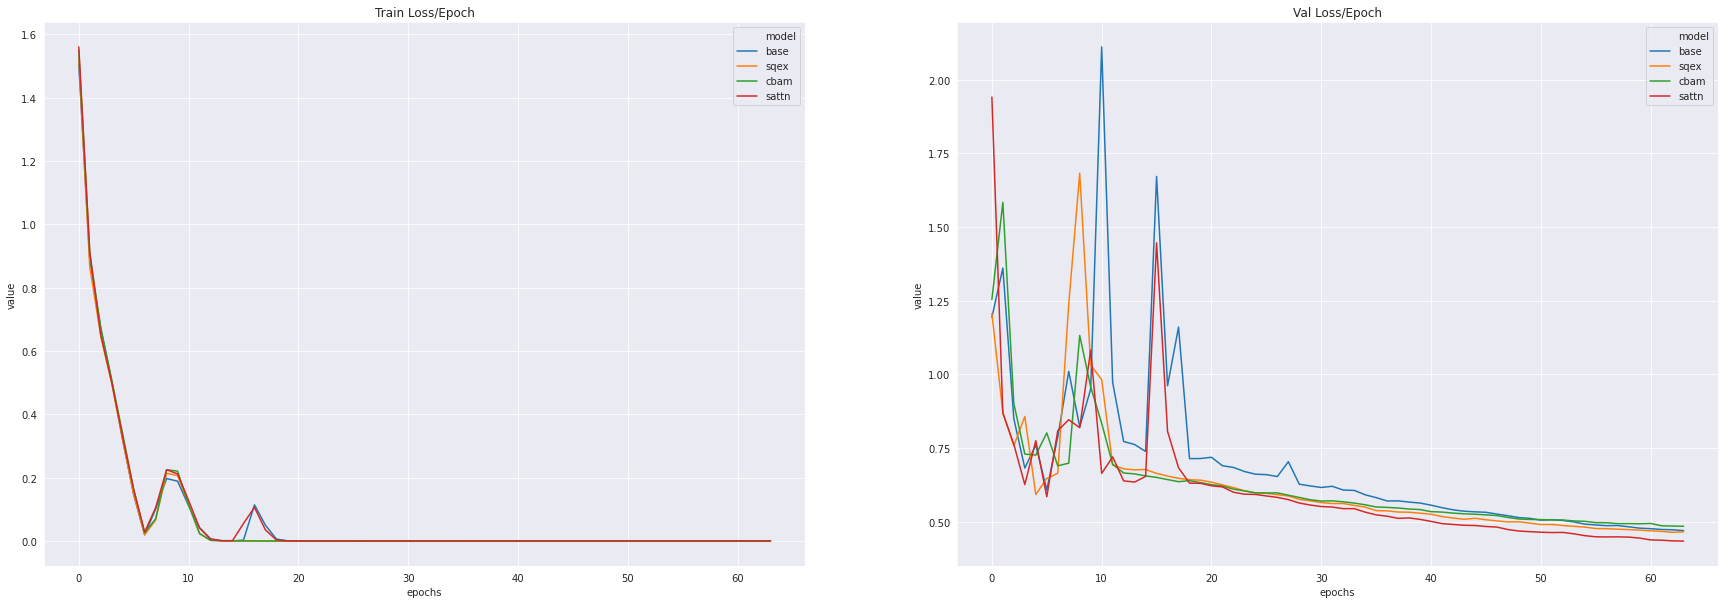

In [39]:
plot_metrics(model_list=model_list, stats_dict=loss_stats, title="Loss")

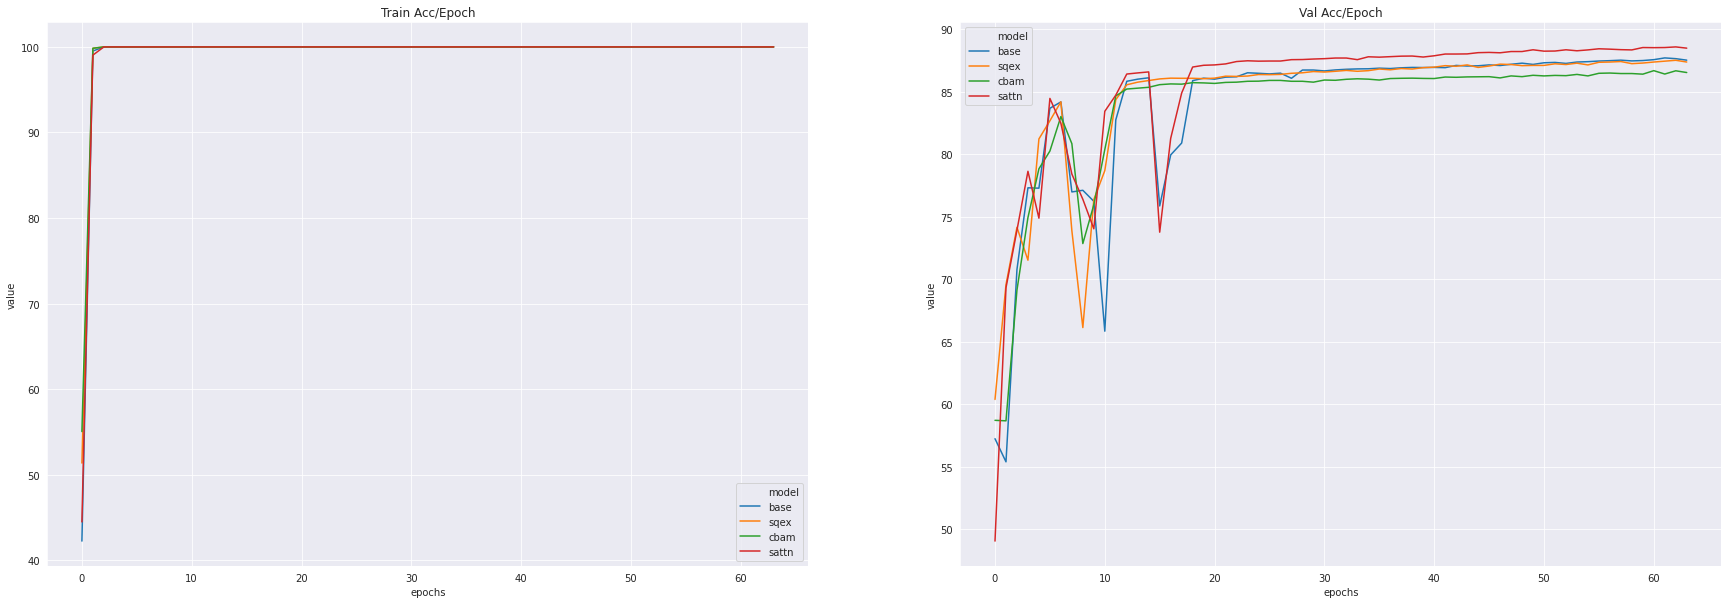

In [41]:
plot_metrics(model_list=model_list, stats_dict=acc_stats, title="Acc")

## Test Model

After training is done, we need to test how our model fared. Note that we've used `model.eval()` before we run our testing code.
To tell PyTorch that we do not want to perform back-propagation during inference, we use `torch.no_grad()`, just like we did it for the validation loop above.

* We start by defining a list that will hold our predictions. Then we loop through our batches using the `test_loader`. For each batch -
* We move our input mini-batch to GPU.
* We make the predictions using our trained model.
* Apply `log_softmax` activation to the predictions and pick the index of highest probability.
* Move the batch to the GPU from the CPU.
* Convert the tensor to a `numpy` object and append it to our list.

### Load Best Models

In [42]:
base_model = ModelImageClassifier(attn_type="base").to(device)
sqex_model = ModelImageClassifier(attn_type="sqex").to(device)
cbam_model = ModelImageClassifier(attn_type="cbam").to(device)
sattn_model = ModelImageClassifier(attn_type="sattn").to(device)

base_model.load_state_dict(
    torch.load("./attention_models/base_channel_factor_8_epoch_64.pt")
)
sqex_model.load_state_dict(
    torch.load("./attention_models/sqex_channel_factor_8_epoch_64.pt")
)
cbam_model.load_state_dict(
    torch.load("./attention_models/cbam_channel_factor_8_epoch_64.pt")
)
sattn_model.load_state_dict(
    torch.load("./attention_models/sattn_channel_factor_8_epoch_64.pt")
)


base_model.eval()
sqex_model.eval()
cbam_model.eval()
sattn_model.eval()

trained_model_list = [base_model, sqex_model, cbam_model, sattn_model]

### Test All Models

In [43]:
y_pred_list = {model.attn_type: [] for model in trained_model_list}
y_true_list = {model.attn_type: [] for model in trained_model_list}

with torch.no_grad():
    model.eval()
    for model in tqdm(trained_model_list):
        print(f"Running inference with {model.attn_type} model.")
        for x_batch, y_batch in tqdm(test_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            y_test_pred = model(x_batch)

            y_test_pred = torch.log_softmax(y_test_pred, dim=1)
            _, y_pred_tag = torch.max(y_test_pred, dim=1)

            y_pred_list[model.attn_type].append(y_pred_tag.squeeze().cpu().item())
            y_true_list[model.attn_type].append(y_batch.squeeze().cpu().item())

Running inference with base model.



Running inference with sqex model.



Running inference with cbam model.



Running inference with sattn model.


### Classification Report

Finally, we print out the classification report which contains the `precision`, `recall`, and the `F1 score`.

In [44]:
for model in trained_model_list:
    model_name = model.attn_type

    print("=" * 50)
    print(f"\n{model_name.upper()} | Classification Report")
    print(classification_report(y_true_list[model_name], y_pred_list[model_name]))


BASE | Classification Report
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      1000
           1       0.95      0.95      0.95      1000
           2       0.84      0.81      0.82      1000
           3       0.75      0.75      0.75      1000
           4       0.82      0.87      0.85      1000
           5       0.83      0.80      0.81      1000
           6       0.88      0.92      0.90      1000
           7       0.92      0.90      0.91      1000
           8       0.93      0.94      0.93      1000
           9       0.94      0.91      0.93      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000


SQEX | Classification Report
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      1000
           1       0.95      0.94      0.94      1000
           2      

### Confusion Matrix

We create a dataframe from the confusion matrix and plot it as a heatmap using the seaborn library.

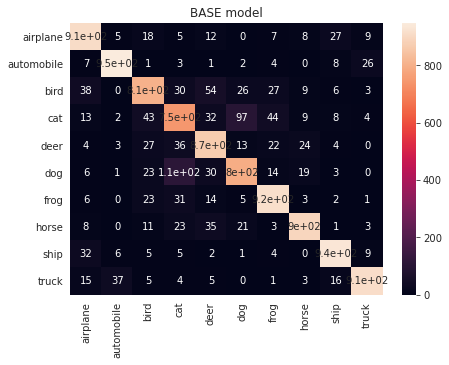

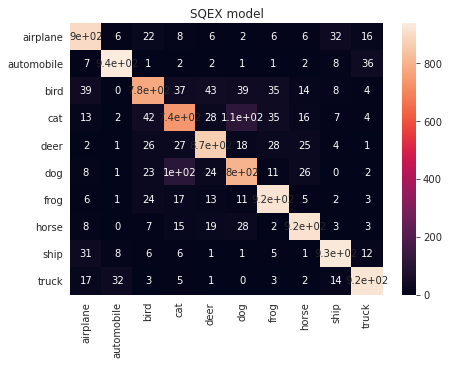

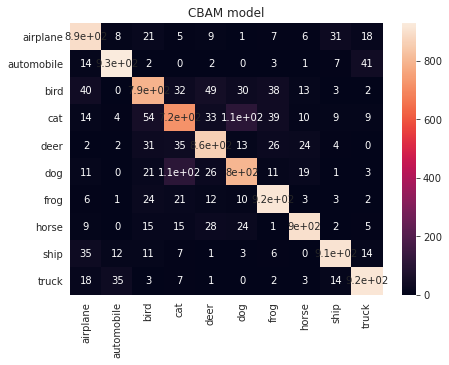

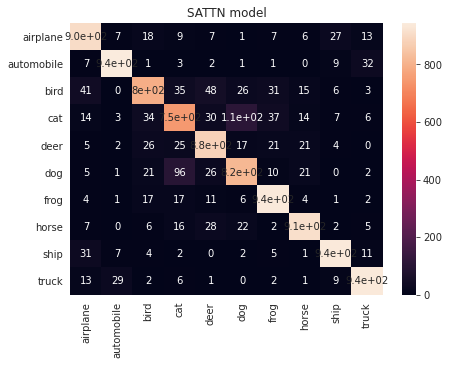

In [45]:
for model in trained_model_list:
    model_name = model.attn_type

    confusion_matrix_df = pd.DataFrame(
        confusion_matrix(y_true_list[model_name], y_pred_list[model_name])
    ).rename(columns=idx2class, index=idx2class)

    fig, ax = plt.subplots(figsize=(7, 5))

    sns.heatmap(confusion_matrix_df, annot=True, ax=ax).set_title(
        f"{model_name.upper()} model"
    )

## Visualize Activation Maps - GradCAM

We'll use GradCAM to visualize the activation maps. We won't redefine the test-loader because we want to compare GradCAM on 2 images.

In [46]:
def make_pred(model, img):
    pred = model(img.to(device))
    pred = torch.softmax(pred, dim=1)
    pred_idx = pred.argmax(dim=1).item()

    return pred, pred_idx


def run_gradcam(model, img, pred):
    pred[:, pred_idx].backward()
    gradients = model.get_gradients()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = model.get_activations(img.to(device)).detach()

    for i in range(activations.size(1)):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze().cpu()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)

    return heatmap.cpu().numpy()


def plot_heatmap_image(im, hm):
    hm = cv2.resize(hm, (32, 32))
    hm = np.uint8(hm * 255)
    hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)

    im = im.squeeze().cpu().permute(1, 2, 0).numpy()
    #     im = np.uint8(im * 255)

    return 0.001 * hm + im


def plot_heatmap_image_grid(test_loader, num_images, model_list):

    fig, axes = plt.subplots(
        nrows=num_images, ncols=len(model_list) + 1, figsize=(num_images*2, num_images*5)
    )

    model_name_list = ["Image"] + [model.attn_type for model in model_list]

    for row, (img, lbl) in enumerate(test_loader):
        if row == num_images:
            break

        temp_final_list = []
        temp_final_list.append(img.squeeze().cpu().permute(1, 2, 0).numpy())

        for model in model_list:

            pred, pred_idx = make_pred(model, img)
            heatmap = run_gradcam(model, img, pred)
            final = plot_heatmap_image(im=img, hm=heatmap)

            temp_final_list.append(final)

        for col, fnl in enumerate(temp_final_list):
            axes[row, col].imshow(fnl)
            axes[row, col].set_title(f"{model_name_list[col]} | class: {idx2class[lbl.item()]}")

    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

### Visualize a Single Image

In [47]:
test_images = iter(test_loader)

In [48]:
single_image, single_label = next(test_images)

True label is : cat

Predicted label is : cat



Text(0.5, 1.0, 'True Image')

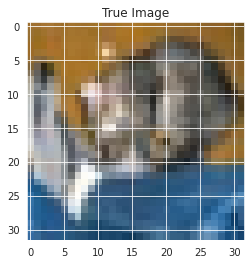

In [49]:
pred, pred_idx = make_pred(base_model, single_image)

print(f"True label is : {idx2class[single_label.item()]}\n")
print(f"Predicted label is : {idx2class[pred_idx]}\n")

plt.imshow(single_image.squeeze().permute(1, 2, 0))
plt.title("True Image")

In [50]:
heatmap = run_gradcam(base_model, single_image, pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


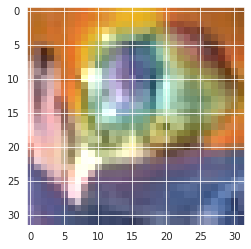

In [51]:
plt.imshow(plot_heatmap_image(im=single_image, hm=heatmap))

### Visualize a Grid

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

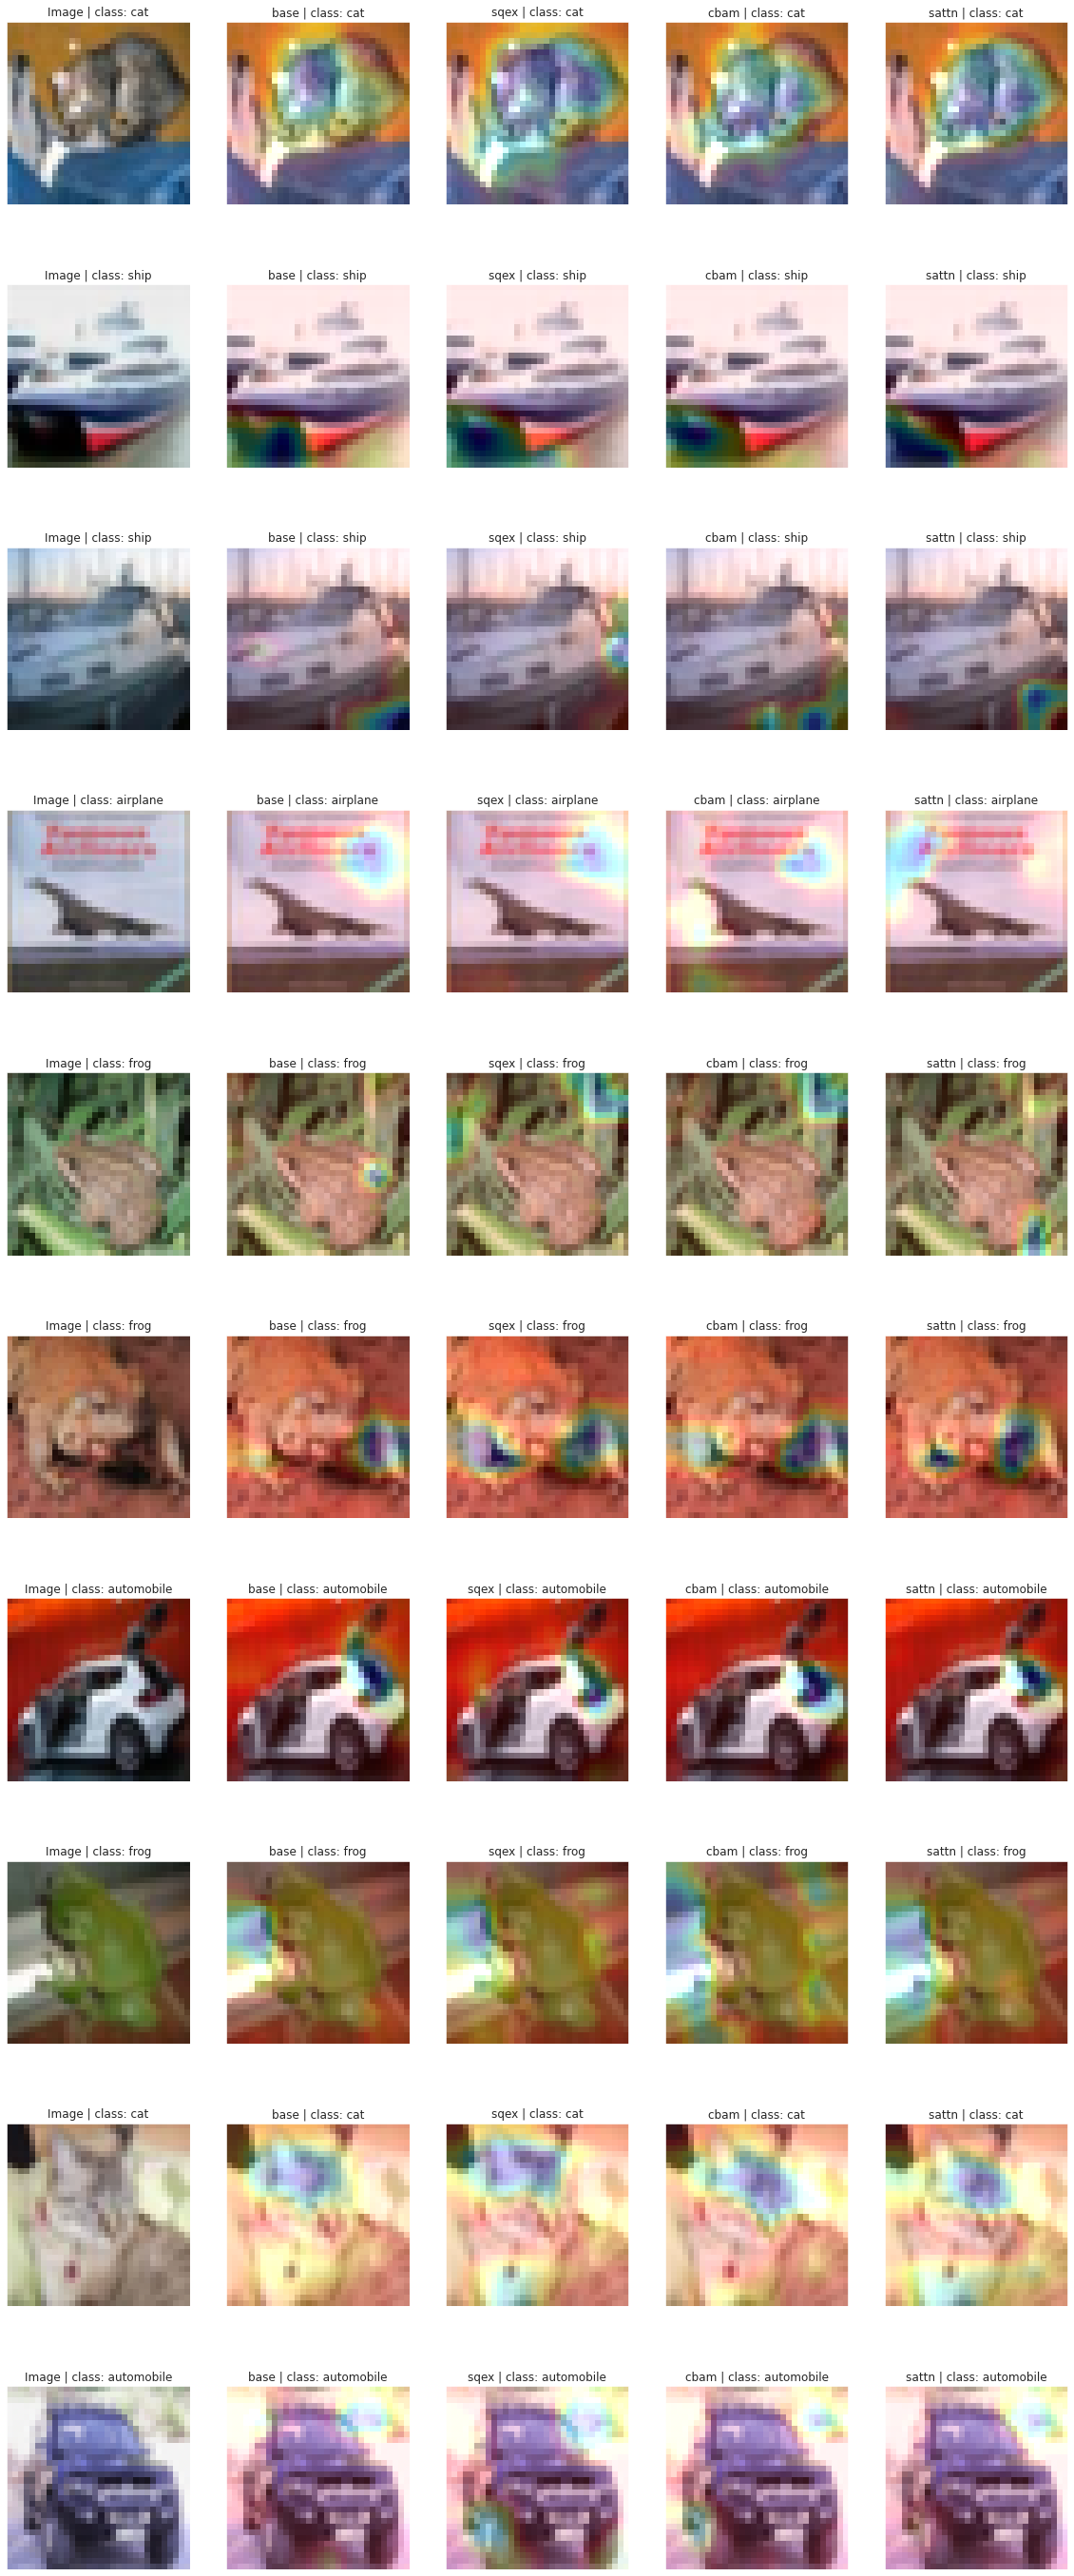

In [52]:
plot_heatmap_image_grid(test_loader, 10, trained_model_list)